In [1]:
!nvidia-smi

Tue Feb 25 23:01:36 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A800-SXM...  Off  | 00000000:C9:00.0 Off |                    0 |
| N/A   45C    P0    64W / 400W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM

path = '/gpfs/share/home/2201110046/Models/deepseek-hf/r1-7B'
tokenizer = AutoTokenizer.from_pretrained(path, padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(path, device_map='cuda:0')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Generate responses

In [14]:
import pandas as pd

df = pd.read_json('datasets/MATH-500/test.jsonl', lines=True)
df.head()

,problem,solution,answer,subject,level,unique_id
0,"Convert the point $(0,3)$ in rectangular coord...",We have that $r = \sqrt{0^2 + 3^2} = 3.$ Also...,"\left( 3, \frac{\pi}{2} \right)",Precalculus,2,test/precalculus/807.json
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,We count the number of times $\frac{1}{n^3}$ a...,p - q,Intermediate Algebra,5,test/intermediate_algebra/1994.json
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",$f(-2)+f(-1)+f(0)=\frac{3(-2)-2}{-2-2}+\frac{3...,\frac{14}{3},Algebra,3,test/algebra/2584.json
3,How many positive whole-number divisors does 1...,First prime factorize $196=2^2\cdot7^2$. The ...,9,Number Theory,3,test/number_theory/572.json
4,The results of a cross-country team's training...,Evelyn covered more distance in less time than...,\text{Evelyn},Algebra,2,test/algebra/1349.json


In [16]:
import torch
from torch.amp import autocast

def decorate_prompts(tokenizer, prompts_raw):
    """
    Apply chat template (and add fix response prefix) to the prompts.
    """
    dialogs = [[{"role":"user", "content":prompt_raw}] for prompt_raw in prompts_raw]
    prompts = tokenizer.apply_chat_template(dialogs, tokenize=False, add_generation_prompt=True)

    return prompts

prompt_raw = df['problem'][0]
promtps = decorate_prompts(tokenizer, [prompt_raw])
inputs = tokenizer(promtps, return_tensors='pt', padding=True, add_special_tokens=False).to(model.device)
print(tokenizer.decode(inputs['input_ids'][0]))

<｜begin▁of▁sentence｜><｜User｜>Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$<｜Assistant｜>


In [5]:
from torch.utils.data import DataLoader

dataloader = DataLoader(df['problem'], batch_size=10, shuffle=False)

In [ ]:
from tqdm import tqdm
from torch.amp import autocast

input_id_list = []
# df_oes = pd.read_parquet('datasets/MATH-500/inputs.parquet')
# input_id_list = df_oes['input_ids'].tolist()

for idx, prompts_raw in enumerate(tqdm(dataloader)):

    prompts = decorate_prompts(tokenizer, prompts_raw)
    inputs = tokenizer(prompts, return_tensors='pt', padding=True, add_special_tokens=False).to(model.device)

    with autocast('cuda'):
        outputs = model.generate(
            **inputs,
            max_new_tokens=8192,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )

        masks = outputs.ne(tokenizer.eos_token_id)
        for output, mask in zip(outputs, masks):
            input_id_list.append(output[mask].tolist())

    if (idx+1)%10==0:
        df_oes = pd.DataFrame({'input_ids':input_id_list})
        df_oes.to_parquet('datasets/MATH-500/output_ids.parquet', index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

/gpfs/share/home/2201110046/.conda/llm_sft/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/gpfs/share/home/2201110046/.conda/llm_sft/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 50/50 [8:14:54<00:00, 593.88s/it]  


In [46]:
df_o = pd.read_parquet('datasets/MATH-500/output_ids.parquet')

prompt_list = []
prompt_res_list = []

responses = []
for prompt_res_ids, prompt_raw in zip(df_o['input_ids'], df['problem']):

    prompts = decorate_prompts(tokenizer, [prompt_raw])
    prompt_ids = tokenizer(prompts, add_special_tokens=False)['input_ids'][0]

    res_len = len(prompt_res_ids)-len(prompt_ids)
    if res_len<=4096:
        prompt_list.append(prompt_ids)
        prompt_res_list.append(prompt_res_ids)

        responses.append(tokenizer.decode(prompt_res_ids))

df_o_filter = pd.DataFrame({'prompt_ids':prompt_list, 'prompt_res_ids':prompt_res_list})
df_o_filter.to_parquet('datasets/MATH-500/output_ids_filter.parquet', index=False)

with open('datasets/MATH-500/responses.txt', 'w') as f:
    f.write('\n\n---\n\n'.join(responses))

## Process data

In [93]:
import pandas as pd

df_o = pd.read_parquet('datasets/MATH-500/output_ids_filter.parquet')

prompt_ids = df_o['prompt_res_ids'][1]
print(tokenizer.decode(prompt_ids))

<｜begin▁of▁sentence｜><｜User｜>If $f(x) = \frac{3x-2}{x-2}$, what is the value of $f(-2) +f(-1)+f(0)$? Express your answer as a common fraction.<｜Assistant｜><think>
Okay, so I have this function f(x) = (3x - 2)/(x - 2), and I need to find the value of f(-2) + f(-1) + f(0). Hmm, let me think about how to approach this. I guess I need to compute each of these function values separately and then add them up. That sounds straightforward enough.

First, let me write down the function again to make sure I have it right: f(x) = (3x - 2)/(x - 2). So, for each x value, I plug it into the numerator and denominator and simplify. Let's start with f(-2).

Calculating f(-2):
The numerator is 3*(-2) - 2. Let me compute that: 3 times -2 is -6, and then subtract 2, so that's -6 - 2 = -8.
The denominator is (-2) - 2, which is -4.
So, f(-2) is (-8)/(-4). Dividing two negatives gives a positive, so that's 2. Okay, so f(-2) is 2.

Next, f(-1):
Numerator: 3*(-1) - 2. 3 times -1 is -3, minus 2 is -5.
Denominat

In [49]:
bot_token_id = tokenizer('<think>', add_special_tokens=False)['input_ids'][0]
eot_token_id = tokenizer('</think>', add_special_tokens=False)['input_ids'][0]
print(bot_token_id, eot_token_id)

wait_pattern = tokenizer('A.\n\nWait, I.\n\nBut, I.\n\n**Final Answer**', add_special_tokens=False)['input_ids']
print(wait_pattern)

151648 151649
[32, 382, 14190, 11, 358, 382, 3983, 11, 358, 382, 334, 19357, 21806, 334]


In [107]:
import torch
import numpy as np

def search_think_range(prompt_ids, bot_token_id=151648, eot_token_id=151649):
    start_pos = np.where(prompt_ids == bot_token_id)[0][0]
    try:
        end_pos = np.where(prompt_ids == eot_token_id)[0][0]
    except:
        end_pos = len(prompt_ids)

    return start_pos, end_pos

# def search_pos(prompt_ids, pos_patterns=[[382, 14190], [382, 3983]]):
def search_pos(prompt_ids, pos_pattern=[382, 334], nega_patter=[[382, 14190], [382, 3983]]):
    start_pos, end_pos = search_think_range(prompt_ids)
    pos_pos_list = []
    nega_pos_list = []
    pos_record = None
    for pos in range(start_pos+1, end_pos):
        if prompt_ids[pos-1] == pos_pattern[0]:
            if prompt_ids[pos] == pos_pattern[1]:
                pos_pos_list.append(pos)
                # if pos_record is not None:
                #     pos_pos_list.append(pos_record)
            # else:
            #     pos_record = pos
        # if (prompt_ids[pos:pos+2] == nega_patter).all():
        #     nega_pos_list.append(pos)

        if prompt_ids[pos-1:pos+1].tolist() in nega_patter:
            nega_pos_list.append(pos)

    return pos_pos_list, nega_pos_list

prompt_ids = df_o['prompt_res_ids'][1]
pos_pos_list, nega_pos_list = search_pos(prompt_ids)

print(pos_pos_list, nega_pos_list)
for pos in pos_pos_list[:5]:
    print(tokenizer.decode(prompt_ids[pos]))
for pos in nega_pos_list[:5]:
    print(tokenizer.decode(prompt_ids[pos]))

[977] [628, 701]
**
Wait
But


In [113]:
from tqdm import tqdm
from torch.amp import autocast
import random

pos_hidden_list = [[] for _ in range(model.config.num_hidden_layers)]
nega_hidden_list = [[] for _ in range(model.config.num_hidden_layers)]

for prompt_ids in tqdm(df_o['prompt_res_ids'][:200]):
    pos_pos_list, nega_pos_list = search_pos(prompt_ids)

    if len(pos_pos_list)>5:
        pos_pos_list = random.sample(pos_pos_list, 5)
    if len(nega_pos_list)>5:
        nega_pos_list = random.sample(nega_pos_list, 5)

    prompt_ids = torch.tensor(prompt_ids).to(model.device).unsqueeze(0)
    with torch.no_grad(), autocast('cuda'):
        outputs = model(prompt_ids, output_hidden_states=True)

    for layer_idx, hiddens in enumerate(outputs.hidden_states[1:]):
        # Get hidden state that generates the target token
        for pos in pos_pos_list:
            pos_hidden_list[layer_idx].append(hiddens[:, pos-1].detach().clone())
        for pos in nega_pos_list:
            nega_hidden_list[layer_idx].append(hiddens[:, pos-1].detach().clone())

pos_hiddens = [torch.cat(hiddens, dim=0) for hiddens in pos_hidden_list]
nega_hiddens = [torch.cat(hiddens, dim=0) for hiddens in nega_hidden_list]

100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


In [64]:
torch.save({'positive': pos_hiddens, 'negative':nega_hiddens}, 'datasets/MATH-500/pos_hiddens.pt')

In [6]:
import torch

record = torch.load('datasets/MATH-500/pos_hiddens.pt')
pos_hiddens = record['positive']
nega_hiddens = record['negative']

/tmp/ipykernel_64122/1641665269.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  record = torch.load('datasets/MATH-500/pos_hiddens.pt')


In [63]:
layer_idx = 15

pos_hiddens_mean = pos_hiddens[layer_idx].mean(dim=0) 
nega_hiddens_mean = nega_hiddens[layer_idx].mean(dim=0)
print((pos_hiddens_mean-nega_hiddens_mean).norm()/nega_hiddens_mean.norm())

tensor(0.2968, device='cuda:0')


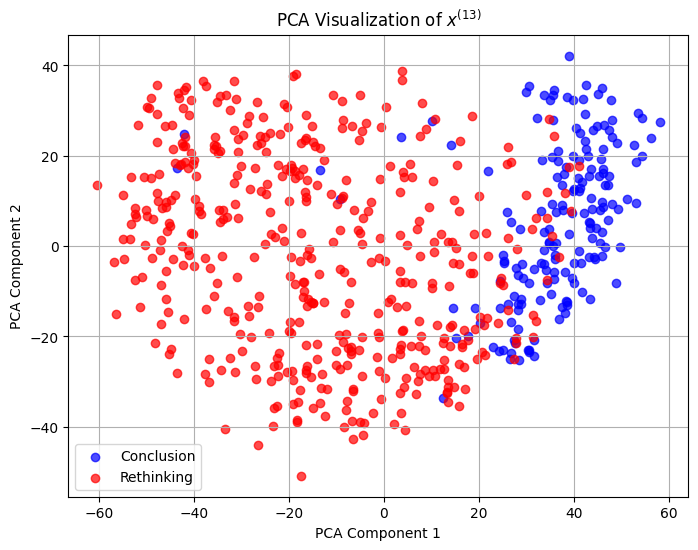

In [166]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example tensors
layer_idx = 13
tensor1 = pos_hiddens[layer_idx]  # First dataset (n1 x d)
tensor2 = nega_hiddens[layer_idx]  # Second dataset (n2 x d)
n1 = tensor1.size(0)

# Convert to NumPy (ensure tensors are on CPU)
data1 = tensor1.cpu().numpy()
data2 = tensor2.cpu().numpy()

# Concatenate both datasets
data = np.vstack([data1, data2])

# Perform PCA (reduce to 2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Split back into original groups
pca_data1 = pca_result[:n1]  # First dataset
pca_data2 = pca_result[n1:]  # Second dataset

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_data1[:, 0], pca_data1[:, 1], color='blue', label='Conclusion', alpha=0.7)
plt.scatter(pca_data2[:, 0], pca_data2[:, 1], color='red', label='Rethinking', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of $x^{(13)}$")
plt.legend()
plt.grid(True)
plt.show()

In [164]:
reload_pack()
from utils import HiddenAblation, HiddenPatch
from tqdm import tqdm
import random
from torch.amp import autocast

for layer_idx in [13, 17]:
# for layer_idx in [13]:
    pos_hidden_mean = pos_hiddens[layer_idx].mean(dim=0) 
    nega_hidden_mean = nega_hiddens[layer_idx].mean(dim=0)
    hidden_gap = pos_hidden_mean-nega_hidden_mean

    modified_forward = HiddenAblation(model, hidden_gap, 1.0)
    # modified_forward = HiddenPatch(model, hidden_gap.view(1,1,-1), layer_idx=layer_idx)
    # modified_forward = HiddenPatch(model, torch.zeros_like(hidden_gap.view(1,1,-1)), layer_idx=layer_idx)

    count = [0, 0]
    responses = []

    random.seed(0)
    for idx in tqdm(range(200, len(df_o))):
        prompt_res_ids = df_o['prompt_res_ids'][idx]

        pos_pos_list, nega_pos_list = search_pos(prompt_res_ids)
        if len(pos_pos_list)==0:
            continue
        else:
            pos = random.choice(pos_pos_list)

        input_ids = prompt_res_ids[:pos]
        input_ids = torch.tensor([input_ids]).to(model.device) # Could accelerate by batch processing

        with autocast('cuda'), modified_forward:
            outputs = model.generate(
                input_ids,
                attention_mask=torch.ones_like(input_ids, dtype=int),
                max_new_tokens=1,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
                )
            responses.append(outputs[0, input_ids.shape[1]:])

            output_id = outputs[0, input_ids.shape[1]]
            if output_id==14190 or output_id==3983: # Wait or But
            # if output_id==334:
                count[1] += 1
            else:
                count[0] += 1

    print(layer_idx, count)
        

100%|██████████| 177/177 [00:27<00:00,  6.39it/s]


13 [93, 55]


100%|██████████| 177/177 [00:27<00:00,  6.39it/s]

17 [52, 96]


10 [78, 70]
11 [78, 70]
12 [85, 63]
13 [93, 55]
14 [80, 68]
15 [68, 80]
16 [68, 80]
17 [52, 96]
18 [63, 85]
19 [54, 94]

### rethink
default: [0, 138]
activ add: [86, 52]
direction abl: [21, 117]

### conclusion
default: [148, 0]
activ add: [20, 128]
direction abl: [52, 96]

/tmp/ipykernel_135801/3423360157.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([bar_label])


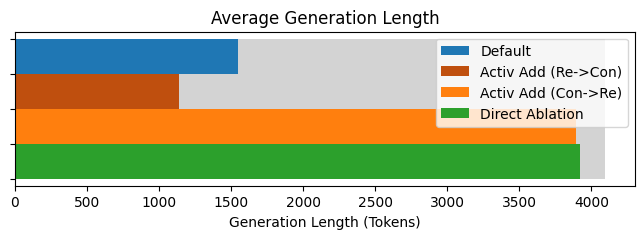

In [211]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the single group (3 bars)
record = [1549.469, 1139.982, 3890.719, 3917.041, ]

# Labels for the bars
bar_label = None

# Maximum value for the full height of the bar (background)
max_value = 4096  # Assume full scale is 100

# Position of the single group on the y-axis
y = np.array([0])  # Single group

# Width of each bar
height = 0.5

# Create the plot
fig, ax = plt.subplots(figsize=(8, 2))

# Plot background (full height for the group)
ax.barh(y, [max_value], 4*height, color='lightgray')

# Plot individual bars on top of the background
for idx, (r, c, n) in enumerate(zip(record, ["#1f77b4", "#bf4f0e", "#ff7f0e", "#2ca02c"], ['Default', 'Activ Add (Re->Con)', 'Activ Add (Con->Re)', 'Direct Ablation'])):
    ax.barh(y-(idx-1.5)*height, [r], height, color=c, label=n)

# Add labels, title, and custom y-axis tick labels
ax.set_xlabel('Generation Length (Tokens)')
ax.set_title('Average Generation Length')
# ax.set_yticks(locs = [y-height, y, y+height,])
ax.set_yticklabels([bar_label])
ax.legend()

# Display the plot
plt.show()


In [175]:
from utils import HiddenPatch

layer_idx = 17

pos_hidden_mean = pos_hiddens[layer_idx].mean(dim=0) 
nega_hidden_mean = nega_hiddens[layer_idx].mean(dim=0)
hidden_gap = (pos_hidden_mean-nega_hidden_mean).view(1,1,-1)

modified_forward = HiddenPatch(model, hidden_gap, layer_idx=layer_idx)
# modified_forward = HiddenAblation(model, hidden_gap, 1.0)

responses = []
for idx in range(200, len(df_o)):
    input_ids = df_o['prompt_res_ids'][idx]

    sot_pos, eot_pos = search_think_range(input_ids)
    print(eot_pos-sot_pos)

    input_ids = torch.tensor([input_ids[:sot_pos+1]]).to(model.device)
    with autocast('cuda'), modified_forward:
        outputs = model.generate(
            input_ids=input_ids,
            max_new_tokens=4095,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            )
        sot_pos, eot_pos = search_think_range(outputs[0].cpu().numpy())
        print(eot_pos-sot_pos)
        # print(tokenizer.decode(outputs[0, sot_pos:]))
        responses.append(outputs.detach().clone())

        if idx%10 == 0:
            torch.save(responses, 'datasets/MATH-500/responses_add_short.pt')
    
# print(tokenizer.decode(outputs[0, prompt_ids.shape[1]:]))

1536


/gpfs/share/home/2201110046/.conda/llm_sft/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/gpfs/share/home/2201110046/.conda/llm_sft/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


525
947
530
1340
4096
997
457
924
363
1083
808
2507
807
2454
934
1869
715
3512
4096
1174
535
2472
1101
1242
260
1289
725
1003
4096
1841
835
2829
524
1023
483
1956
2151
2613
4096
2062
4096
1664
4096
2002
674
1231
620
1252
189
1093
978
880
611
1445
263
3215
4096
2682
2085
1136
497
2902
1095
1363
522
1794
1038
518
309
706
475
256
200
1315
1430
1873
4096
1439
762
825
488
3179
4096
1737
619
857
622
2023
1086
1263
671
882
558
1452
971
1242
964
889
963
1798
937
1788
808
2125
723
1835
734
2792
799
1801
654
1548
940
1017
523
610
604
1346
701
1267
834
1692
762
1444
740
2152
716
1593
512
806
605
1679
1003
2650
978
1731
129
1380
1096
1516
688
1586
945
1429
562
2092
4096
1508
841
750
494
741
620
1021
536
1773
1192
137
382
1310
933
1037
825
2763
1055
1148
474
2450
1904
2597
1192
1933
4096
1236
1063
713
308
243
178
1496
483
1227
659
1492
550
2052
1231
2218
4096
1888
4096
845
627
2349
506
205
196
254
138
176
108
1240
698
992
553
1222
564
252
79
943
875
2934
2047
1011
473
1040
299
3029
4096
1519
519
11

In [181]:
# responses = torch.load('datasets/MATH-500/responses_abl.pt')
responses = pd.read_parquet('datasets/MATH-500/output_ids_filter.parquet')['prompt_res_ids'][200:]

count = 0
for outputs in responses:
    # sot_pos, eot_pos = search_think_range(outputs[0].cpu().numpy())
    sot_pos, eot_pos = search_think_range(outputs)
    gen_len = eot_pos-sot_pos
    count += gen_len

print(count/len(responses))

1549.4689265536724


In [ ]:
abl: 3917.041
add (long): 3890.719
add (short): 1139.982

default: 1549.469

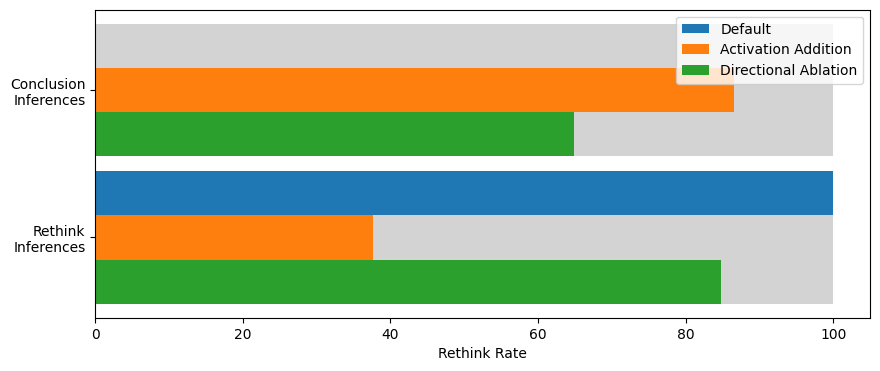

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
group1 = [100.0, 0.0]  # Values for the first group
group2 = [100*52/(86+52), 100*128/(20+128)]  # Values for the second group
group3 = [100*117/(21+117), 100*96/(52+96)] 

# Labels for the bars
bar_labels = ['Rethink\nInferences', 'Conclusion\nInferences']

# Positions of the bars on the x-axis
x = np.arange(len(bar_labels))

# Width of each bar
width = 0.3

# Create the plot
fig, ax = plt.subplots(figsize=(10, 4,))

# Create the bars
ax.barh(x, 100, 3*width, color='lightgray')
rects1 = ax.barh(x + width, group1, width, label='Default')
rects2 = ax.barh(x, group2, width, label='Activation Addition')
rects2 = ax.barh(x - width, group3, width, label='Directional Ablation')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Rethink Rate')
# ax.set_title('Grouped Bar Plot')
ax.set_yticks(x)
# ax.set_xlim([-0.1, 1.1])
ax.set_yticklabels(bar_labels)
ax.legend(loc=1)

# Display the plot
plt.show()

In [81]:
numbers = [
    1345, 1117, 1480, 678, 2162, 3002, 3303, 3491, 985, 2600, 937, 818, 906, 703, 
    1718, 988, 991, 799, 1174, 1402, 601, 972, 1750, 1456, 2316, 1129, 1194, 772, 
    1485, 1285, 1903, 935, 2143, 1631, 1440, 913, 875, 751, 1315, 1273, 227, 213, 
    3012, 2912, 770, 586, 735, 571, 1095, 1041, 1511, 595, 1478, 1280, 3261, 2558, 
    840, 1252, 2757, 2417, 2220, 1818, 1748, 1547, 730, 1160, 1748, 1883, 946, 659, 
    1320, 1269, 637, 330, 1021, 1223, 925, 1121, 2196, 1153, 172, 147, 1728, 1190, 
    874, 667, 2701, 2724, 1874, 1957, 3013, 4097, 926, 984, 179, 802, 1468, 1630,
]
count = 0
num_pairs = int(len(numbers)/2)
for idx in range(num_pairs):
    count += numbers[2*idx] - numbers[2*idx+1]

print(count/num_pairs)

114.9795918367347


In [40]:
for r in responses:
    print(tokenizer.decode(r[0]))

<｜begin▁of▁sentence｜><｜User｜>The equation
\[x^{10}+(13x-1)^{10}=0\,\]has 10 complex roots $r_1,$ $\overline{r}_1,$ $r_2,$ $\overline{r}_2,$ $r_3,$ $\overline{r}_3,$ $r_4,$ $\overline{r}_4,$ $r_5,$ $\overline{r}_5,$ where the bar denotes complex conjugation. Find the value of
\[\frac 1{r_1\overline{r}_1}+\frac 1{r_2\overline{r}_2}+\frac 1{r_3\overline{r}_3}+\frac 1{r_4\overline{r}_4}+\frac 1{r_5\overline{r}_5}.\]<｜Assistant｜><think>
Okay, so I have this equation: \(x^{10} + (13x - 1)^{10} = 0\). It's a 10th-degree polynomial, so there should be 10 roots, right? And they're all complex because it's a high-degree polynomial. The problem says the roots come in conjugate pairs: \(r_1, \overline{r}_1, r_2, \overline{r}_2\), and so on up to \(r_5, \overline{r}_5\). 

I need to find the sum \(\frac{1}{r_1\overline{r}_1} + \frac{1}{r_2\overline{r}_2} + \dots + \frac{1}{r_5\overline{r}_5}\). Hmm, okay. So each term is the reciprocal of the product of a root and its conjugate. I remember that for

In [28]:
logits_gap = model.lm_head(hidden_gap)
print(logits_gap[0, 0, 334].item())
up_tokens = torch.topk(logits_gap[0,0], 10).indices
values = torch.topk(logits_gap[0,0], 10).values
for t, v in zip(up_tokens, values):
    print(f"{v.item():.3f},  {tokenizer.decode(t)}")

0.8236072063446045
4.273,  -END
4.234,  总而言之
3.927,   bookmark
3.885,   reasonably
3.697,   $?
3.595,   repost
3.568,   buffering
3.529,   '**
3.508,   nostalg
3.503,   {!


adding pos-nega: [72, 0, 13]

adding nega-pos: [61, 14, 8]

In [ ]:
from utils import HiddenPatch

responses = []
for idx in range(100):
    input_ids = df_o['prompt_res_ids'][idx]

    sot_pos, eot_pos = search_think_range(input_ids)
    input_ids = torch.tensor([input_ids[:eot_pos-1].tolist()+[92, 382, 14190,]]).to(model.device)
    with autocast('cuda'), modified_forward:
        outputs = model.generate(
            input_ids=input_ids,
            max_new_tokens=4096,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            )
        # sot_pos, eot_pos = search_think_range(outputs[0].cpu().numpy())
        print(tokenizer.decode(outputs[0, sot_pos:eot_pos+1]))
        print('\n--------\n')
        print(tokenizer.decode(outputs[0, eot_pos+1:]))
        responses.append(outputs.detach().clone())

    break

/gpfs/share/home/2201110046/.conda/llm_sft/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/gpfs/share/home/2201110046/.conda/llm_sft/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


<think>
Okay, so I need to convert the rectangular coordinate (0, 3) to polar coordinates. Hmm, I remember that polar coordinates are represented as (r, θ), where r is the radius or the distance from the origin to the point, and θ is the angle made with the positive x-axis. 

First, let me recall the formulas for converting rectangular coordinates (x, y) to polar coordinates (r, θ). I think r is calculated using the Pythagorean theorem, so r = sqrt(x² + y²). And θ is found using the arctangent function, θ = arctan(y/x). But wait, I also remember that sometimes arctan(y/x) isn't enough because it doesn't account for the correct quadrant. So, I need to consider the signs of x and y to determine the correct angle.

Looking at the point (0, 3), x is 0 and y is 3. Let me plug these into the formula for r. So, r = sqrt(0² + 3²) = sqrt(0 + 9) = sqrt(9) = 3. Okay, that seems straightforward. So, r is 3.

Now, onto θ. Since x is 0, I need to be careful because dividing by zero is undefined. I r

In [67]:
print(tokenizer.decode(outputs[0, sot_pos:eot_pos+1]))
print('--------\n')
print(tokenizer.decode(outputs[0, eot_pos+1:]))

<think>
Okay, so I need to convert the rectangular coordinate (0, 3) to polar coordinates. Hmm, I remember that polar coordinates are represented as (r, θ), where r is the radius or the distance from the origin to the point, and θ is the angle made with the positive x-axis. 

First, let me recall the formulas for converting rectangular coordinates (x, y) to polar coordinates (r, θ). I think r is calculated using the Pythagorean theorem, so r = sqrt(x² + y²). And θ is found using the arctangent function, θ = arctan(y/x). But wait, I also remember that sometimes arctan(y/x) isn't enough because it doesn't account for the correct quadrant. So, I need to consider the signs of x and y to determine the correct angle.

Looking at the point (0, 3), x is 0 and y is 3. Let me plug these into the formula for r. So, r = sqrt(0² + 3²) = sqrt(0 + 9) = sqrt(9) = 3. Okay, that seems straightforward. So, r is 3.

Now, onto θ. Since x is 0, I need to be careful because dividing by zero is undefined. I r

In [ ]:
input_ids = df_o['prompt_res_ids'][0]
sot_pos, eot_pos = search_think_range(input_ids)
prompt = tokenizer.decode(input_ids[:eot_pos])
# print(prompt)
input_ids = torch.tensor([input_ids[:eot_pos-1].tolist()+[92, 382, 14190,]]).to(model.device)

prompts_new = tokenizer.decode(input_ids[0])
print(prompts_new[-100:])

dinates are (3, π/2).

**Final Answer**
The polar coordinates are \boxed{(3, \dfrac{\pi}{2})}.

Wait


In [56]:
tokenizer.decode(tokenizer(prompt+'\n\n')['input_ids'][-10:])

' \\dfrac{\\pi}{2})}.\n\n\n'

In [29]:
import pandas as pd
import torch

df = pd.read_parquet('datasets/MATH-500/output_ids_filter.parquet')

In [30]:
responses = []

for p, pr in df[['prompt_ids', 'prompt_res_ids']].values[200:371]:
    start_pos = len(p)
    responses.append(pr[start_pos:])

df_new = pd.DataFrame({'prompts': df['prompt_ids'][200:371], 'responses':responses})
df_new.to_parquet('results/default.parquet', index=False)

In [ ]:
responses_original = torch.load('datasets/MATH-500/responses_add_long.pt')
responses = []
for p, pr in zip(df['prompt_ids'][200:371], responses_original):
    pr = pr[0].tolist()
    start_pos = len(p)
    # print(tokenizer.decode(pr[start_pos:]))
    responses.append(pr[start_pos:])

df_new = pd.DataFrame({'prompts': df['prompt_ids'][200:371], 'responses':responses})
df_new.to_parquet('results/activation_addition_r2c.parquet', index=False)

/tmp/ipykernel_1268410/1176509488.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  responses_original = torch.load('datasets/MATH-500/responses_add_short.pt')


"<think>\nOkay, so I need to convert the rectangular coordinate (0, 3) to polar coordinates. Hmm, I remember that polar coordinates are represented as (r, θ), where r is the radius or the distance from the origin to the point, and θ is the angle made with the positive x-axis. \n\nFirst, let me recall the formulas for converting rectangular coordinates (x, y) to polar coordinates (r, θ). I think r is calculated using the Pythagorean theorem, so r = sqrt(x² + y²). And θ is found using the arctangent function, θ = arctan(y/x). But wait, I also remember that sometimes arctan(y/x) isn't enough because it doesn't account for the correct quadrant. So, I need to consider the signs of x and y to determine the correct angle.\n\nLooking at the point (0, 3), x is 0 and y is 3. Let me plug these into the formula for r. So, r = sqrt(0² + 3²) = sqrt(0 + 9) = sqrt(9) = 3. Okay, that seems straightforward. So, r is 3.\n\nNow, onto θ. Since x is 0, I need to be careful because dividing by zero is undefi